## DC correction

гипотеза: поправка зависит от угла, не зависит от энергии, зависит от сезона

In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import iminuit
from iminuit.cost import LeastSquares

import pylib.style as pys
import pylib.preprocess as preprocess

In [2]:
# plt.style.use('./pylib/cmd1202.mplstyle')

In [49]:
SEASON = '19'
FIT_RANGE = (-40, 20)

In [50]:
t_exp = uproot.open(f'../trees/{SEASON}/exp.root')['t']
t_mc  = uproot.open(f'../trees/{SEASON}/mc.root')['t']

In [51]:
df_exp = preprocess.read_tree(t_exp, mc=False, z_cut=12)
df_mc = preprocess.read_tree(t_mc, mc=True, z_cut=12)
# df_lum = pd.read_csv(f'/storeA/ryzhenenkov/lum20{SEASON}.dat', sep='\t', names=['energy', 'lum', 'lum_err'], index_col='energy') 

In [52]:
def handle_data(df, ang_cut):
    FIT_RANGE = (-5, 5)
    df0 = df.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}').copy()
    df0 = df0.loc[(np.abs(df0['tz[0]'])<10) & (np.abs(df0['tz[1]'])<10)].copy()
    select_tracks = lambda df: df.loc[(np.abs(df['tth[0]'] - np.pi/2)<ang_cut)|(np.abs(df['tth[1]'] - np.pi/2)<ang_cut) ].copy()
    select_tracks2 = lambda df: df.loc[(np.abs(df['tth[0]'] - np.pi/2)<ang_cut)&(np.abs(df['tth[1]'] - np.pi/2)<ang_cut) ].copy()
    df = select_tracks(df0)[['tth[0]', 'tth[1]', 'tptot[0]', 'tptot[1]']].rename({'tth[0]' : 'th0', 'tth[1]' : 'th1', 
                                                                                  'tptot[0]' : 'p0', 'tptot[1]' : 'p1'}, axis=1)
    df = df.append(select_tracks2(df0)[['tth[0]', 'tth[1]', 'tptot[0]', 'tptot[1]']].rename({'tth[0]' : 'th1', 'tth[1]' : 'th0', 
                                                                     'tptot[0]' : 'p1', 'tptot[1]' : 'p0'}, axis=1))
    df['ortos'] = np.argmax((np.abs(df[['th0', 'th1']] - np.pi/2) < ang_cut).values, axis=1)
    df['longs'] = 1-df['ortos']
    df['ortoAngle'] = np.where(df.ortos==0, df['th0'], df['th1'])
    df['longAngle'] = np.where(df.longs==0, df['th0'], df['th1'])
    df['ortoP'] = np.where(df.ortos==0, df['p0'], df['p1'])
    df['longP'] = np.where(df.longs==0, df['p0'], df['p1'])
    return df

In [53]:
ang_cut = 0.3

In [54]:
df_exp_handled = handle_data(df_exp, ang_cut)
df_mc_handled = handle_data(df_mc, ang_cut)

get_lens = lambda df: df.loc[(np.abs(df['longAngle'] - np.pi/2)<ang_cut)].groupby('ebeam').agg(counts = ('ortoAngle', 'count'))

weights = pd.merge(get_lens(df_exp_handled), get_lens(df_mc_handled), on='ebeam', suffixes=['_exp', '_mc'])
weights['w'] = weights['counts_exp']/weights['counts_mc']

df_mc_handled = df_mc_handled.join(weights).dropna()
df_exp_handled = df_exp_handled.join(weights).dropna()

In [55]:
df_exp_handled.index.unique()

Float64Index([537.5, 550.0, 562.5, 575.0, 587.5, 600.0, 612.5, 625.0, 637.5,
              641.0, 650.0, 662.5, 675.0, 687.5, 700.0, 712.5, 725.0, 737.5,
              750.0, 762.0, 775.0, 787.5, 800.0, 812.5, 825.0, 837.5, 850.0,
              862.5, 875.0, 912.5, 936.0, 945.0, 950.0, 951.1, 962.5, 975.0,
              978.0, 987.5],
             dtype='float64', name='ebeam')

In [56]:
len(df_exp_handled.loc[(np.abs(df_exp_handled['longAngle'] - np.pi/2)<ang_cut)])

2958

In [57]:
df_exp_handled.head()

,th0,th1,p0,p1,ortos,longs,ortoAngle,longAngle,ortoP,longP,counts_exp,counts_mc,w
ebeam,,,,,,,,,,,,,
537.5,1.425534,2.139219,304.971161,143.951935,0,1,1.425534,2.139219,304.971161,143.951935,746.0,748.0,0.997326
537.5,1.455213,2.234391,258.594757,198.424026,0,1,1.455213,2.234391,258.594757,198.424026,746.0,748.0,0.997326
537.5,1.894865,1.394899,153.818985,293.625671,1,0,1.394899,1.894865,293.625671,153.818985,746.0,748.0,0.997326
537.5,2.126732,1.562193,199.503021,252.910767,1,0,1.562193,2.126732,252.910767,199.503021,746.0,748.0,0.997326
537.5,1.666386,1.924007,188.319763,270.338135,0,1,1.666386,1.924007,188.319763,270.338135,746.0,748.0,0.997326


In [58]:
d1, _ = np.histogram(df_exp_handled.longAngle, bins=8, range=(np.pi/2 - ang_cut, np.pi/2 + ang_cut));
d2, _ = np.histogram(df_mc_handled.longAngle, bins=8, weights=df_mc_handled.w, range=(np.pi/2 - ang_cut, np.pi/2 + ang_cut));
print(d1.sum(), d2.sum())

2958 2958.00000000001


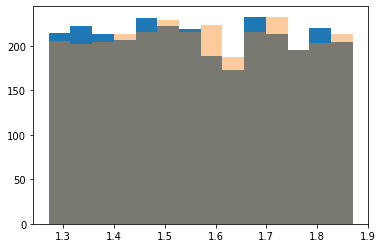

In [59]:
plt.hist(df_exp_handled.longAngle, bins=14, range=(np.pi/2 - ang_cut, np.pi/2 + ang_cut));
plt.hist(df_mc_handled.longAngle, bins=14, range=(np.pi/2 - ang_cut, np.pi/2 + ang_cut), weights=df_mc_handled.w, alpha=0.4);

In [60]:
def get_ratio(df_exp_handled, df_mc_handled, hist_range, hist_bins, column='longAngle'):
    exp_hist, bins = np.histogram(df_exp_handled[column], bins=hist_bins, range=hist_range)
    mc_hist, bins = np.histogram(df_mc_handled[column], bins=hist_bins, range=hist_range, weights=df_mc_handled.w)

    exp_hist = np.ma.masked_array(exp_hist)
    exp_hist[exp_hist==0] = np.ma.masked

    mc_hist = np.ma.masked_array(mc_hist)
    mc_hist[exp_hist==0] = np.ma.masked
    
    mc_errs = []
    for left, right in zip(bins[:-1], bins[1:]):
        mc_errs.append( np.sqrt( np.sum( np.extract((df_mc_handled.longAngle<=right)&(df_mc_handled.longAngle>left), df_mc_handled.w)**2 ) ) )
    mc_errs = np.array(mc_errs)
    
    ratio = exp_hist/mc_hist
    ratio_err = ratio*np.sqrt( (1/np.sqrt(exp_hist))**2 + (mc_errs/mc_hist)**2 )
    ratio[ratio.mask] = np.nan
    ratio_err[ratio_err.mask] = np.nan
    df = pd.DataFrame({'left': bins[:-1],
     'right': bins[1:],
     'dc_corr': ratio.data,
     'dc_corr_err': ratio_err.data,
    })
    return df

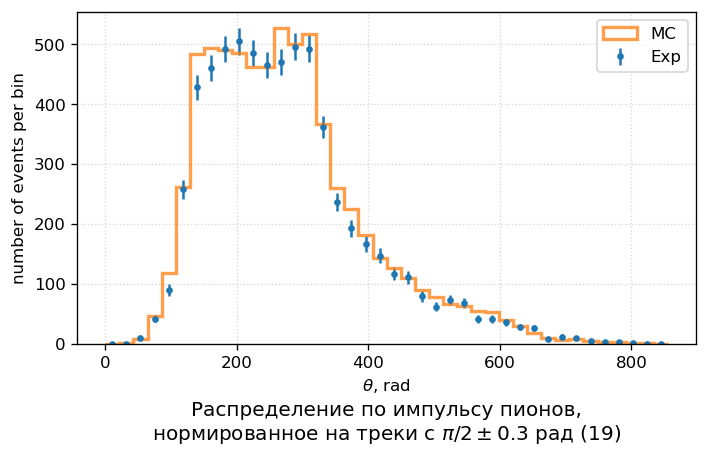

In [61]:
hist_range_P, hist_bins_P = (0, df_mc_handled.longP.max()), 40
plt.figure(dpi=120)
# plt.hist(a, range=hist_range, bins=hist_bins);
pys.hep_histo(df_exp_handled.longP, bins=hist_bins_P, range=hist_range_P, label='Exp');
plt.hist(df_mc_handled.longP, weights=df_mc_handled.w, range=hist_range_P, bins=hist_bins_P, alpha=0.75, histtype='step', lw=2, label='MC');
plt.legend();
plt.title('Распределение по импульсу пионов,\nнормированное на треки с $\\pi/2 \pm {}$ рад ({})'.format(ang_cut, SEASON), y=-0.32)
plt.ylabel('number of events per bin')
plt.xlabel('$\\theta$, rad');
plt.ylim(0, None)
plt.grid(ls=':', alpha=0.5)
plt.tight_layout()
# plt.savefig(f'./images/08DC/pi_P_{SEASON}.png', dpi=160)

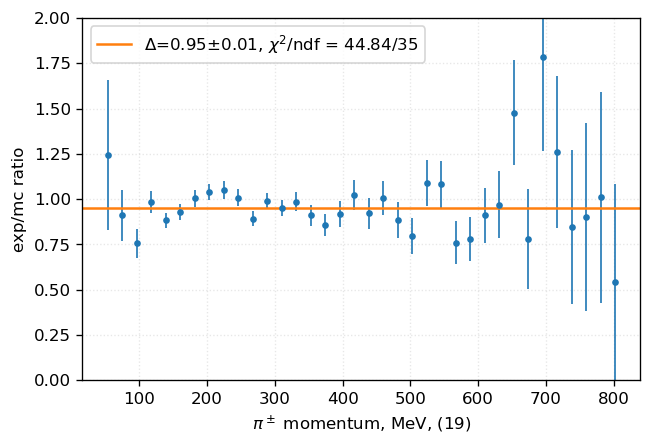

In [70]:
df_ratioP = get_ratio(df_exp_handled, df_mc_handled, hist_range_P, hist_bins_P, 'longP')
dtemp = df_ratioP.dropna()
costF = LeastSquares((dtemp.left + dtemp.right)/2, dtemp.dc_corr, dtemp.dc_corr_err, lambda x, a: a)
m = iminuit.Minuit(costF, a=1)
m.migrad();
plt.figure(dpi=120)
plt.errorbar((dtemp.left + dtemp.right)/2, dtemp.dc_corr, yerr=dtemp.dc_corr_err, fmt='.', lw=1)
plt.xlim((None, None))
plt.ylim(0, 2)
plt.plot([0, 1e4], np.full(2, m.values['a']), label='$\Delta$={:.2}$\pm${:.2f}, $\chi^2$/ndf = {:.2f}/{}'.format(m.values['a'], m.errors['a'], m.fval, len(dtemp)-1))
plt.xlabel(f'$\pi^\pm$ momentum, MeV, ({SEASON})');
plt.legend()
plt.grid(ls=':', alpha=0.3)
plt.ylabel('exp/mc ratio');
# plt.savefig(f'./images/08DC/pi_P_ratio_{SEASON}.png', dpi=160)

Можно ли считать константой распределение сверху ☝️?

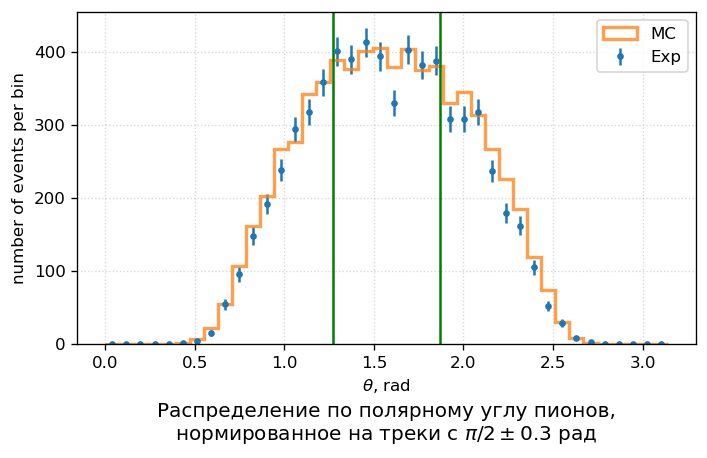

In [63]:
hist_range, hist_bins = (0, np.pi), 40
plt.figure(dpi=120)
# plt.hist(a, range=hist_range, bins=hist_bins);
pys.hep_histo(df_exp_handled.longAngle, bins=hist_bins, range=hist_range, label='Exp');
plt.hist(df_mc_handled.longAngle, weights=df_mc_handled.w, range=hist_range, bins=hist_bins, alpha=0.75, histtype='step', lw=2, label='MC');
plt.legend();
plt.title('Распределение по полярному углу пионов,\nнормированное на треки с $\\pi/2 \pm {}$ рад'.format(ang_cut), y=-0.32)
plt.ylabel('number of events per bin')
plt.xlabel('$\\theta$, rad');
plt.ylim(0, None)
plt.grid(ls=':', alpha=0.5)
plt.plot(np.ones(2)*(np.pi/2-ang_cut), [0, 1e6], color='g')
plt.plot(np.ones(2)*(np.pi/2+ang_cut), [0, 1e6], color='g')
plt.tight_layout()
# plt.savefig(f'./images/slides/pi_th_{SEASON}.png', dpi=160)
# pys.my_style(title='$\\theta$')

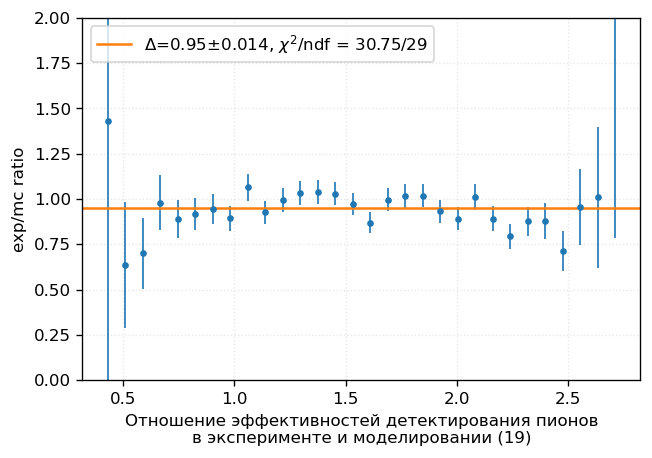

In [69]:
df_ratioTh = get_ratio(df_exp_handled, df_mc_handled, hist_range, hist_bins, 'longAngle')
dtemp = df_ratioTh.dropna()
costF = LeastSquares((dtemp.left + dtemp.right)/2, dtemp.dc_corr, dtemp.dc_corr_err, lambda x, a: a)
m = iminuit.Minuit(costF, a=1)
m.migrad();
plt.figure(dpi=120)
plt.errorbar((dtemp.left + dtemp.right)/2, dtemp.dc_corr, yerr=dtemp.dc_corr_err, fmt='.', lw=1)
plt.xlim((None, None))
plt.ylim(0, 2)
plt.plot([0, 5], np.full(2, m.values['a']), label='$\Delta$={:.2}$\pm${:.3f}, $\chi^2$/ndf = {:.2f}/{}'.format(m.values['a'], m.errors['a'], m.fval, len(dtemp)-1))
plt.xlabel(f'Отношение эффективностей детектирования пионов\nв эксперименте и моделировании ({SEASON})');
plt.legend()
plt.grid(ls=':', alpha=0.3)
plt.ylabel('exp/mc ratio');
# plt.savefig(f'./images/08DC/pi_ratio_{SEASON}.png', dpi=160)

In [65]:
df = df_ratioTh.copy()

In [66]:
df.head(20)

,left,right,dc_corr,dc_corr_err
0,0.000000,0.078540,NaN,NaN
1,0.078540,0.157080,NaN,NaN
2,0.157080,0.235619,NaN,NaN
3,0.235619,0.314159,NaN,NaN
4,0.314159,0.392699,NaN,NaN
5,0.392699,0.471239,1.430819,1.533172
6,0.471239,0.549779,0.634883,0.346178
7,0.549779,0.628319,0.701232,0.196672
8,0.628319,0.706858,0.980899,0.151412
9,0.706858,0.785398,0.890356,0.104488


## Подсчитываю поправки

Как считаю поправки, и что важнее, ошибки к поправке:

Обозначения: 
* $c$ - поправка к эффективности ДК; 
* $\Delta_i$ - отношение эфф. ДК для одного пиона в эксперименте к моделированию в $i$-м бине
* $n_{ij}$ - количество KS с одним распадным пионом из $i$-го бина, а вторым из $j$-го
* $N = \sum_{i,j} n_{ij}$ - количество событий


$$ c = \frac{\sum_{i,j} \Delta^i \Delta^j n_{ij} }{ \sum_{i,j} n_{ij} } $$


теперь считаю ошибку ($\delta c$) определения поправки к ДК по формуле переноса ошибок, в случае использования формулы выше не возникает проблем с ковариациями между случайными величинами, т.к. $\Delta_i$ независимы от $n_{ij}$ и друг от друга

$$ \begin{aligned}
    \delta c^2 = \sum_i {\big( \frac{\partial c}{\partial \Delta_i} \delta \Delta_i  \big)}^2 + \sum_{i,j} { \big( \frac{\partial c}{\partial n_{ij}} \delta n_{ij} \big) }^2 = \\
    = \sum_i { \bigg( \frac{ \sum_j \Delta^j ( n_{ij} + n_{ji} )}{N} \delta \Delta_i \bigg) }^2 + \sum_{i,j} { \big( \frac{ \Delta_i \Delta_j - c }{N} \delta n_{ij} \big) }^2
\end{aligned}$$

In [21]:
df = df.fillna(1)

In [22]:
df_mc_cut = df_mc.query(f'x1>{FIT_RANGE[0]}&x1<{FIT_RANGE[1]}').copy()

In [23]:
df_mc_cut['bin0'] = np.digitize(df_mc_cut['tth[0]'], df.right)
df_mc_cut['bin1'] = np.digitize(df_mc_cut['tth[1]'], df.right)

In [24]:
dfn = df_mc_cut.groupby(['ebeam', 'bin0', 'bin1'])[['x1']].agg(n=('x1','count')).reset_index().set_index('ebeam')
dfn[['d0', 'd0_err']] = df.loc[dfn['bin0'], ['dc_corr', 'dc_corr_err']].values
dfn[['d1', 'd1_err']] = df.loc[dfn['bin1'], ['dc_corr', 'dc_corr_err']].values

In [25]:
df_means = (dfn['d0']*dfn['d1']*dfn['n']).groupby('ebeam').agg('sum')/dfn['n'].groupby('ebeam').agg('sum')
df_means.name = 'dc_corr'
df_N = dfn['n'].groupby('ebeam').agg('sum')
df_N.name = 'N'

In [26]:
dfn = dfn.join(df_means).join(df_N)

In [27]:
dfn.head()

,bin0,bin1,n,d0,d0_err,d1,d1_err,dc_corr,N
ebeam,,,,,,,,,
537.5,7,27,1,0.701232,0.196672,0.890071,0.069057,0.918559,2273
537.5,7,31,1,0.701232,0.196672,0.711106,0.110603,0.918559,2273
537.5,8,27,2,0.980899,0.151412,0.890071,0.069057,0.918559,2273
537.5,8,32,2,0.980899,0.151412,0.956238,0.207596,0.918559,2273
537.5,9,28,1,0.890356,0.104488,0.794846,0.069252,0.918559,2273


In [28]:
def calc_errors(df0):
    N_mat = np.zeros((len(df), len(df)))
    N_mat[tuple(df0[['bin0', 'bin1']].values.T)] = df0.n.values
    N0 = df0.N.iloc[0]
    c = df0.dc_corr.iloc[0]
    delta = df.dc_corr.values
    ddelta = df.dc_corr_err.values
    err = np.sqrt(np.sum( ((delta@(N_mat + N_mat.T))*ddelta)**2 + np.diag((((delta.reshape((-1,1))@delta.reshape((1,-1))) - c)@np.sqrt(N_mat)))**2 ))/N0
    return pd.Series({'dccorr': c, 'dccorr_err': err})

In [29]:
df_corrs = dfn.groupby('ebeam').apply(calc_errors)
df_corrs.head()

,dccorr,dccorr_err
ebeam,,
537.5,0.918559,0.028538
550.0,0.918711,0.028676
562.5,0.914068,0.028630
575.0,0.912066,0.028823
587.5,0.914794,0.029324


<ErrorbarContainer object of 3 artists>

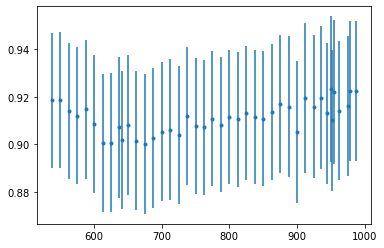

In [30]:
plt.errorbar(df_corrs.index, df_corrs.dccorr, yerr=df_corrs.dccorr_err, fmt='.')
# plt.ylim(0.85, 1);

In [178]:
# df_corrs[['dccorr', 'dccorr_err']].to_csv(f'../data/{SEASON}/results/dc_n2.csv')

[Colab](https://colab.research.google.com/drive/1msDOYxVIUNqdtEvqNDBmPXx-zNfUXRH1?usp=sharing)

In [261]:
th0 = np.digitize(df_mc_cut['tth[0]'], df.right)
th1 = np.digitize(df_mc_cut['tth[1]'], df.right)
df_mc_cut['bin0'], df_mc_cut['bin1'] = th0, th1 
th0, th1 = df.loc[th0, ['dc_corr', 'dc_corr_err']], df.loc[th1, ['dc_corr', 'dc_corr_err']]

df_mc_cut['th0_corr'] = th0['dc_corr'].values
df_mc_cut['th1_corr'] = th1['dc_corr'].values
df_mc_cut['dc_corr'] = th0['dc_corr'].values*th1['dc_corr'].values
df_mc_cut['dc_corr_err'] = df_mc_cut['dc_corr']*np.sqrt( (th0['dc_corr_err'].values/th0['dc_corr'].values)**2 + \
                                                (th1['dc_corr_err'].values/th1['dc_corr'].values)**2 )
# df_mc_cut['dc_corr_sqr'] = df_mc_cut['dc_corr_err']**2 + df_mc_cut['dc_corr']**2

*Дополнения*

Как считается поправка (**так я считал раньше и это неверно, т.к. между $w_i$ есть неучтённые корреляции**)

$$ c = \frac{\sum_{i=0}^{N} w_i n_i}{\sum_{i=0}^{N} n_i} $$

$$ {\delta c}^2 = \sum_{i=0}^{N} { \bigg(\frac{\partial c}{\partial w_i} \bigg)}^2 {\delta w_i}^2 + {\bigg(\frac{\partial c}{\partial n_i} \bigg)}^2 {\delta n_i}^2  $$

известно, что $\sum_{i=0}^{N} n_{i} = N$ и $n_1 = n_2 = ... = n_i = 1$, поэтому

$$ {\delta c}^2 = \sum_{i=0}^{N} {\bigg( \frac{n_i}{N} \bigg)}^2 {\delta w_i}^2 + {\bigg(\frac{w_i - c}{N} \bigg)}^2 {\delta n_i}^2 $$,
$$ {\delta c}^2 = \frac{1}{N^2} \sum_{i=0}^{N} \bigg( {\delta w_i}^2 + {\Delta w_i}^2 \bigg) \text{, где } \Delta w_i = w_i - c$$


In [263]:
df_mc_cut['mean'] = df_mc_cut.groupby('ebeam').agg(dc_corr=('dc_corr', 'mean'))
df_mc_cut['dc_corr_sqr'] = df_mc_cut['dc_corr_err']**2 + (df_mc_cut['dc_corr'] - df_mc_cut['mean'])**2

In [264]:
df_mc_cut.head()

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,x2,ksangle,bin0,bin1,th0_corr,th1_corr,dc_corr,dc_corr_err,mean,dc_corr_sqr
ebeam,,,,,,,,,,,,,,,,,,,,,
537.5,70914,537.453979,1,2.005805,0.816097,0.241445,-0.888369,143.569092,311.319489,-1.844756,...,11.027215,0.044126,25,10,0.891752,0.916372,0.817176,0.097485,0.918559,0.019782
537.5,70914,537.453979,3,1.064023,2.009341,0.545712,0.701725,207.671967,250.174591,0.497540,...,-1.257558,0.080803,13,25,1.064513,0.891752,0.949282,0.094097,0.918559,0.009798
537.5,70914,537.453979,3,1.970497,1.382862,-1.777212,-1.631636,237.645996,216.820862,-0.814446,...,-6.574769,0.001292,25,17,0.891752,1.036982,0.924731,0.086935,0.918559,0.007596
537.5,70914,537.453979,0,2.408521,0.762875,1.424839,0.784493,144.529068,325.263489,0.291321,...,6.397012,0.082735,30,9,0.878829,0.890356,0.782470,0.127765,0.918559,0.034844
537.5,70914,537.453979,1,1.289119,1.322422,2.290584,4.131159,314.527557,138.146713,0.471966,...,5.061947,0.017841,16,16,1.032667,1.032667,1.066401,0.094226,0.918559,0.030736


In [265]:
dd = df_mc_cut.groupby('ebeam').agg(W=('dc_corr', 'sum'), N=('dc_corr', 'count'), dW=('dc_corr_sqr', 'sum'))
dd['dW'] = np.sqrt(dd['dW'])/dd['N']
dd['dccorr'] = dd['W']/dd['N']
dd['dccorr_err'] = dd['dW']
# dd['dccorr_err'] = dd['dccorr']*np.sqrt( (dd['dW']/dd['W'])**2 + (np.sqrt(dd['N'])/dd['N'])**2 )
dd

,W,N,dW,dccorr,dccorr_err
ebeam,,,,,
537.5,2087.884528,2273,0.003041,0.918559,0.003041
550.0,1931.130855,2102,0.003146,0.918711,0.003146
562.5,1838.190629,2011,0.003344,0.914068,0.003344
575.0,1708.299945,1873,0.003949,0.912066,0.003949
587.5,1625.588355,1777,0.004362,0.914794,0.004362
600.0,1510.093447,1662,0.004172,0.908600,0.004172
612.5,1451.720752,1612,0.004534,0.900571,0.004534
625.0,1361.962235,1512,0.004633,0.900769,0.004633
637.5,1289.935096,1422,0.005073,0.907127,0.005073


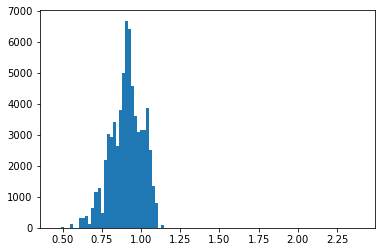

In [266]:
plt.hist(df_mc_cut.dc_corr, bins=100);

<ErrorbarContainer object of 3 artists>

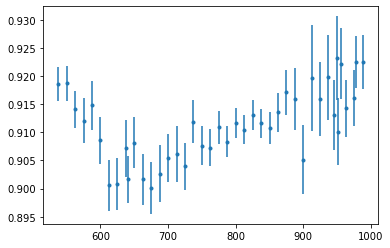

In [267]:
df_mc2 = dd
plt.errorbar(x=df_mc2.index, y=df_mc2.dccorr, yerr=df_mc2.dccorr_err, fmt='.')
# plt.ylim(1, 1.3);

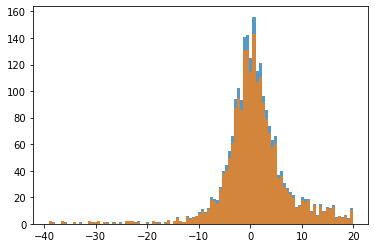

In [268]:
d1 = df_mc_cut.loc[537.5]
plt.hist(d1.x1, bins=100, alpha=0.75);
plt.hist(d1.x1, weights=d1.dc_corr, bins=100, alpha=0.75);

In [29]:
from pylib import fit as pyfit

In [44]:
params = {
    'n_sig': (2000, (0.1, None)),
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'y0'   : (   0.1, (0, None)),
    'dy'   : (   0.1, (0, None)),
}

Binned NLL

In [ ]:
xmin, xmax = (-40, 20)
width = xmax - xmin

In [130]:
@nb.njit(parallel=False, fastmath=True)
def cruijff(x, m, sL, sR, aL, aR):
    denom = 2*np.where(x<m, (sL**2 + aL*(x-m)**2), (sR**2 + aR*(x-m)**2) )
    return np.exp(-(x-m)**2/denom)

In [138]:
from scipy.integrate import quad
from iminuit.cost import ExtendedBinnedNLL
from iminuit import Minuit
import numba as nb

def sig_cdf(x, m, sL, sR, aL, aR, fit_range):
    xmin, xmax = fit_range
    I = quad(cruijff, xmin, xmax, args=(m, sL, sR, aL, aR))[0]
    return np.array([quad(cruijff, xmin, i, args=(m, sL, sR, aL, aR))[0] for i in x])/I

In [163]:
def fitBinnedNLL(data, params, weights=None, weights_errs=None):
    params = params.copy()
    data = data[(data>=xmin)&(data<=xmax)]
    if weights is None:
        dt, bns = np.histogram(data, 50)
    else:
        dt, bns = np.histogram(data, 50, weights=weights)
        dt2, bns = np.histogram(data, 50, weights=weights_errs**2)
        dt2 = dt2 + dt
    cost_function = ExtendedBinnedNLL(np.array([dt, dt2]).T, bns, lambda x, n_sig, m, sL, sR, aL, aR: n_sig*sig_cdf(x, m, sL, sR, aL, aR, (xmin, xmax)))
    del params['y0'], params['dy']
    
    parameters = {k : params[k][0] for k in params}
    m = Minuit(cost_function, **parameters)
    for par in m.parameters:
        m.limits[par] = params[par][1]
    return m

In [151]:
dt, bns = np.histogram(d1.x1, 50, weights=d1.dc_corr)
dt2, bns = np.histogram(d1.x1, 50, weights=d1.dc_corr_err**2)

<ErrorbarContainer object of 3 artists>

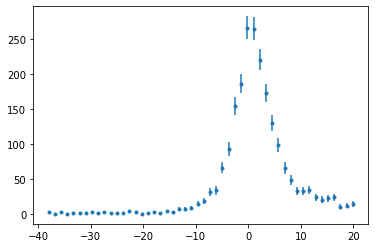

In [162]:
plt.errorbar(bns[1:], dt, yerr=np.sqrt(dt2 + dt), fmt='.')

In [164]:
fitBinnedNLL(d1.x1, params, d1.dc_corr, d1.dc_corr_err).migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 28.77                      │              Nfcn = 227              │
│ EDM = 1.39e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │  2.15e3   │  0.05e3   │            │            │   0.1   │         │       │
│ 1 │ m     │   0.00    │   0.23    │            │            │   -5    │    5    │       │
│ 2 │ sL    │   2.76    │   0.16    │            │            │    1    │   10    │       │
│ 3 │ sR    │   2.93    │   0.23    │            │            │    1    │   10    │       │
│ 4 │ aL    │   0.090   │   0.004   │            │            │    0    │   10    │       │
│ 5 │ aR    │   0.150   │   0.008   │            │            │    0    │   10    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │     n_sig         m        sL        sR        aL        aR │
├───────┼─────────────────────────────────────────────────────────────┤
│ n_sig │  2.18e+03     0.225     0.132    -0.348   0.00153   0.00897 │
│     m │     0.225    0.0515    0.0275   -0.0386 -0.000342  0.000839 │
│    sL │     0.132    0.0275    0.0248    -0.016 -0.000355  0.000455 │
│    sR │    -0.348   -0.0386    -0.016    0.0515  0.000262  -0.00128 │
│    aL │   0.00153 -0.000342 -0.000355  0.000262  1.58e-05 -5.53e-06 │
│    aR │   0.00897  0.000839  0.000455  -0.00128 -5.53e-06  6.97e-05 │
└───────┴─────────────────────────────────────────────────────────────┘

In [61]:
# df_mc2[['dccorr', 'dccorr_err']].to_csv(f'../data/{SEASON}/results/dc_n2.csv')

NameError: name 'df_mc2' is not defined

In [51]:
df_mc2

,dccorr,count,dccorr_err
ebeam,,,
537.5,0.942832,2273,0.001936
550.0,0.942916,2102,0.002008
562.5,0.943384,2011,0.002085
575.0,0.942716,1873,0.002179
587.5,0.940565,1777,0.002200
600.0,0.940348,1662,0.002277
612.5,0.929591,1612,0.002307
625.0,0.934890,1512,0.003145
637.5,0.941487,1422,0.002455
